In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow.contrib.image import transform as H_transform
import yaml
proj_home_path="C:/vrsk.psk.family/Selva/BitsPilani/azure/semester4/semester4/SuperPoint"
sys.path.append(proj_home_path)

from superpoint.settings import EXPER_PATH
from superpoint.models.utils import box_nms 
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Superpoint reader

In [30]:
def _path(filename):
    val = Path(filename.decode('utf-8'))
    return str(val)

def _name(filename):
    val = Path(filename.decode('utf-8')).stem
    return val

def _read_image(filename):
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    return tf.cast(image, tf.float32)

def _read_points(filename):
    return np.load(filename.decode('utf-8')).astype(np.int32)

def _read_super_points(filename):
    mp = np.load(filename, allow_pickle=True)
    name = _name(filename)
    image = mp['image']
    warped_image = mp['warped_image']
    
    keypoints = np.where(mp['prob'] > 0)
    prob = mp['prob'][keypoints[0], keypoints[1]]
    keypoints = np.stack([keypoints[0], keypoints[1]], axis=-1)
    warped_keypoints = np.where(mp['warped_prob'] > 0)
    warped_prob = mp['warped_prob'][warped_keypoints[0], warped_keypoints[1]]
    warped_keypoints = np.stack([warped_keypoints[0],
                                 warped_keypoints[1]], axis=-1)
   

    return [mp['prob'], mp['desc'], name, image, keypoints.astype(np.int32)]
#     return [mp['prob'], mp['warped_prob'], mp['desc'], mp['warped_desc'], mp['homography'], name, image, warped_image , keypoints.astype(np.int32),  warped_keypoints.astype(np.int32)]


def super_points(filename):
    pred_result = tf.py_func(_read_super_points, [filename], [tf.float32, tf.float32, tf.string, tf.float32, tf.int32 ])
    f_output=  {'prob': pred_result[0], 
            'desc': pred_result[1], 'name': pred_result[2],
            'image': pred_result[3], 'points': pred_result[4]}
    return f_output

In [31]:
def get_file_listing(npz_csv_list_path, pred_path_list):

    f = np.load(npz_csv_list_path, allow_pickle=True)
    generated_list = [str(f) for f in os.listdir(pred_path_list)]
    match_list = []
    output_list = []
    pair_list = []

    for files_batch in f['image']:
    #     print('files_batch: ', files_batch)
        for file in files_batch:
            if file.replace('.jpg','.npz') in generated_list:
                match_list.append(file.replace('.jpg','.npz'))
        if len(match_list) >= 2:
              output_list.append(match_list)

        match_list = []
    
    #forming pairs
    for ilist in output_list:
        for l, idx in zip(ilist, range(0,len(ilist)) ):
            if idx == 0:
                ref_image = l
            else:
                pair_list.append([ref_image, l])
    return output_list, pair_list



def getDataIter(data_dir, pair_list, num_images_per_shape ):
      

    pair_list_with_path = [ [os.path.join(data_dir, f[0]), os.path.join(data_dir, f[1])] for f in pair_list]
   
    ref_image_path = [i[0] for i in pair_list_with_path ]
    comp_image_path = [i[1] for i in pair_list_with_path ]
    
    print(ref_image_path, comp_image_path)
    data = tf.data.Dataset.from_tensor_slices((ref_image_path, comp_image_path))
    
    data = data.map(
            lambda ref_image_path, comp_image_path:
                (
                   super_points(ref_image_path),
                   super_points(comp_image_path), 
                  
                )   
    )
    
    data = data.map(
            lambda ref_superpoint, comp_superpoint:
                {
                   'ref_superpoint' : ref_superpoint,
                   'comp_superpoint' : comp_superpoint, 
                  
        }   
    )
   
    
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)

## Read CSV file lists.
npz_csv_list_path = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\data\\PM\\test_list.npz"

##find fist match
pred_path_list = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1"




In [32]:
def select_k_best(points, k):
        """ Select the k most probable points (and strip their proba).
        points has shape (num_points, 3) where the last coordinate is the proba. """
#         print(points.shape)
        sorted_prob = points[points[:, 2].argsort(), :2]
        start = min(k, points.shape[0])
        return sorted_prob[-start:, :].astype(int)

def calculate_match_with_different(data1, data2, keep_k_points=1000, correctness_thresh=3):
    """
    Compute the homography between 2 sets of detections and descriptors inside data.
    """
#     print(data1.keys(), data2.keys())
    prob1 = data1['prob']
    keypoints1 = np.where(prob1 > 0)
    prob1 = prob1[keypoints1[0], keypoints1[1]]
    keypoints1 = np.stack([keypoints1[0], keypoints1[1], prob1], axis=-1)
    top_keypoints1 = select_k_best(keypoints1, keep_k_points)
    desc1 = data1['desc'][top_keypoints1[:, 0], top_keypoints1[:, 1]]

    prob2 = data2['prob']
    keypoints2 = np.where(prob2 > 0)
    prob2 = prob2[keypoints2[0], keypoints2[1]]
    keypoints2 = np.stack([keypoints2[0], keypoints2[1], prob2], axis=-1)
    top_keypoints2 = select_k_best(keypoints2, keep_k_points)
    desc2 = data2['desc'][top_keypoints2[:, 0], top_keypoints2[:, 1]]
        
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc1, desc2)
    matches_idx = np.array([m.queryIdx for m in matches])
    
#     print('matches: ', matches)
    
    if len(matches_idx) == 0:  # No match found
        print('==============No Match Found==================')
        return {
                'keypoints1': top_keypoints1,
                'keypoints2': top_keypoints2,
                'inliers' : [],
                'matches': []}
    
    m_keypoints1 = top_keypoints1[matches_idx, :]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_keypoints2 = top_keypoints2[matches_idx, :]

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(m_keypoints1[:, [1, 0]],
                                    m_keypoints2[:, [1, 0]],
                                    cv2.RANSAC)

    return {
            'keypoints1': top_keypoints1,
            'keypoints2': top_keypoints2,
            'inliers' : np.concatenate(inliers),
            'matches': matches}

def draw_matches(data):
    keypoints1 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints1']]
    keypoints2 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints2']]
    inliers = data['inliers'].astype(bool)
    matches = np.array(data['matches'])
    print('matches.shape, len(inliers): ', matches.shape, len(inliers))
    matches = matches[inliers].tolist()
    img1 = np.concatenate([data['image1'], data['image1'], data['image1']], axis=2) * 255
    img2 = np.concatenate([data['image2'], data['image2'], data['image2']], axis=2) * 255
    return cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches,
                           None, matchColor=(0,255,0), singlePointColor=(0, 0, 255))

['C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\ce538d5b430e0a4035e844bd55a9642d.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\ce538d5b430e0a4035e844bd55a9642d.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\05ab3fb7954d9b61c1e18546c8d51eca.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\05ab3fb7954d9b61c1e18546c8d51eca.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\05ab3fb7954d9b61c1e18546c8d51eca.npz'] ['C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\cadc873c6e7e744ac821a96f1f9c2a75.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment

<Figure size 432x288 with 0 Axes>

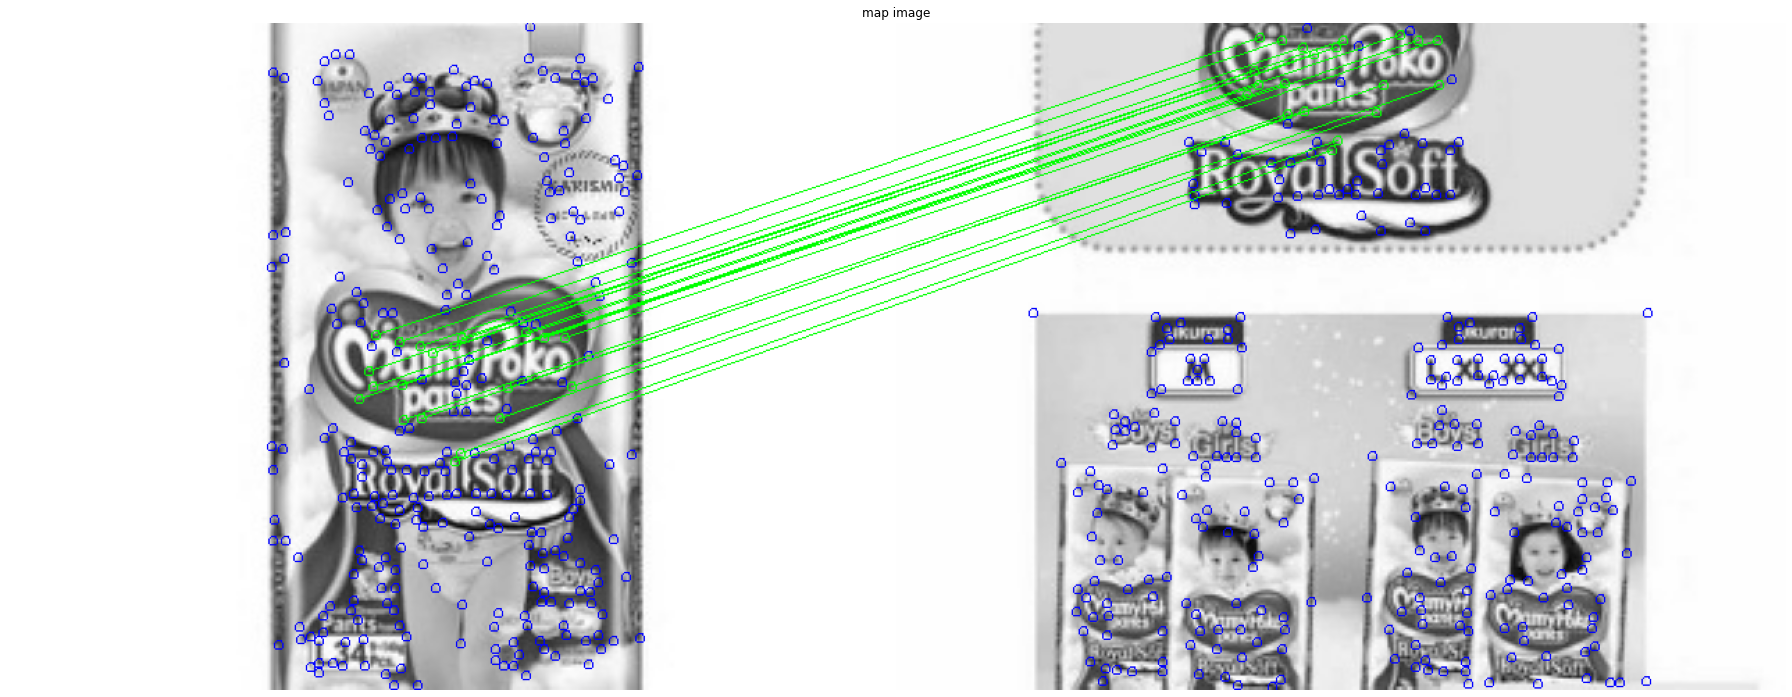

<Figure size 432x288 with 0 Axes>

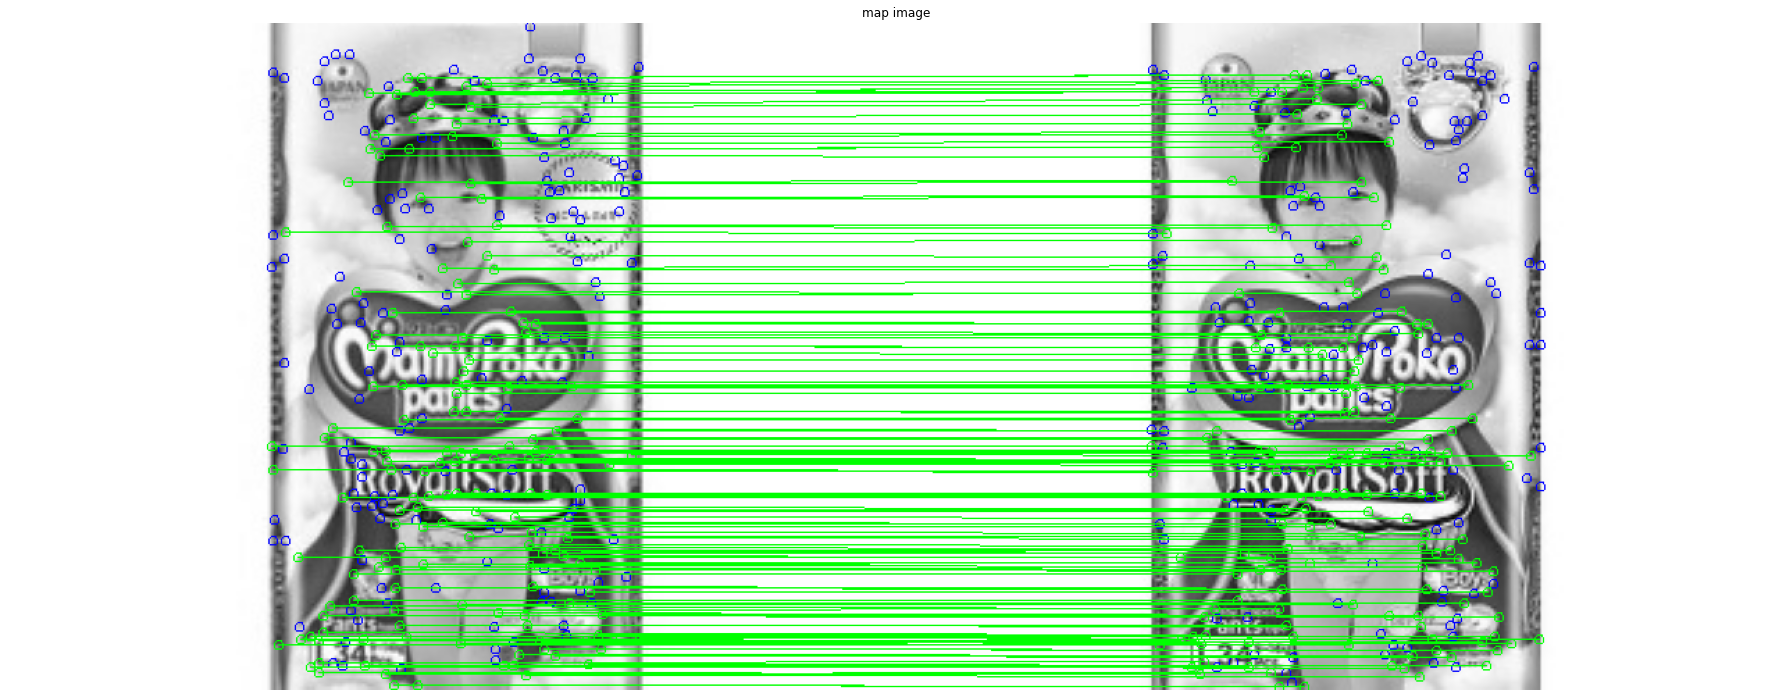

<Figure size 432x288 with 0 Axes>

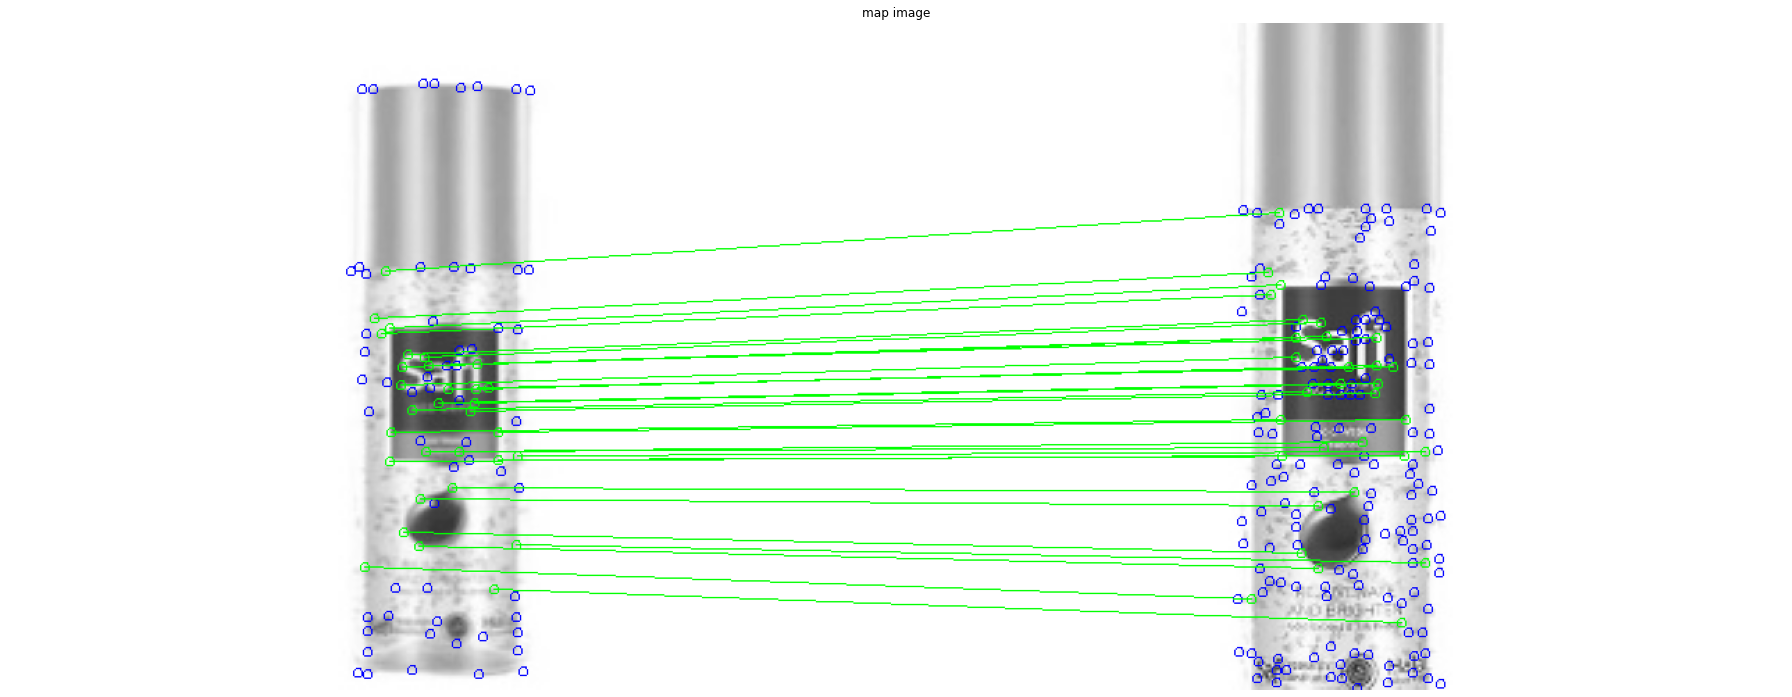

<Figure size 432x288 with 0 Axes>

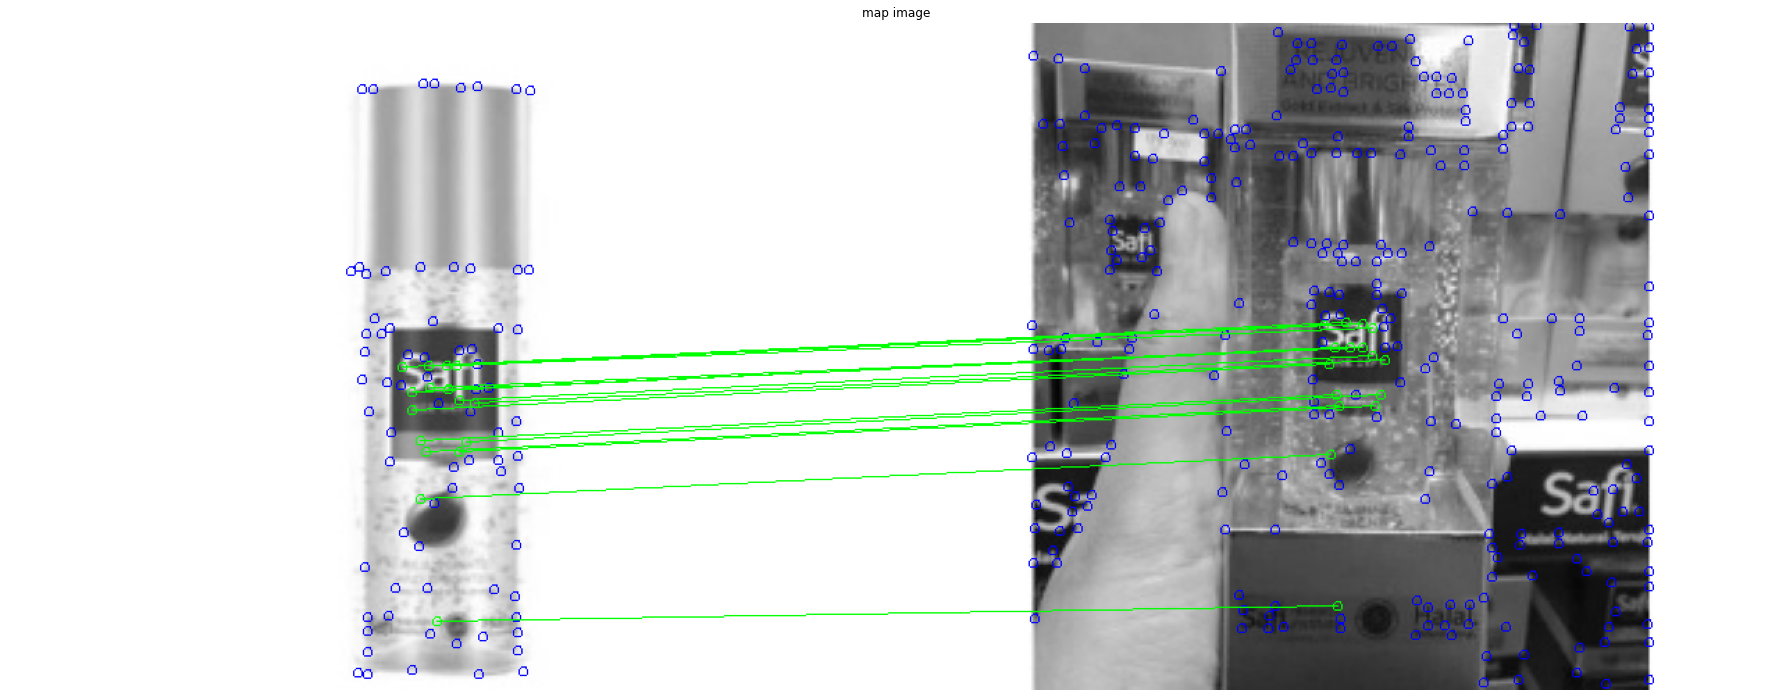

<Figure size 432x288 with 0 Axes>

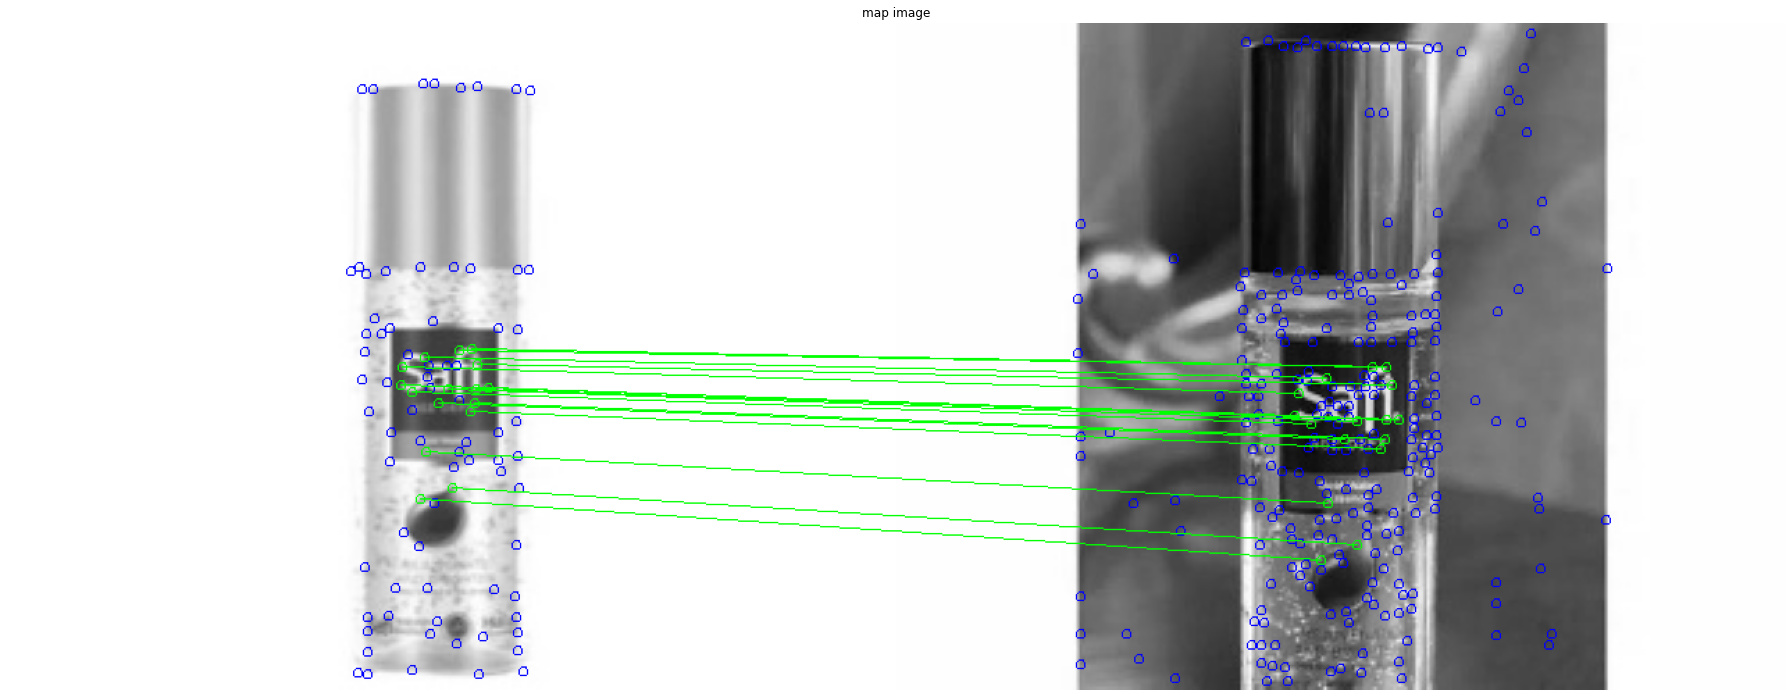

In [5]:
output_list, pair_list = get_file_listing(npz_csv_list_path, pred_path_list)

num_images_per_shape = 2

data = getDataIter(pred_path_list, pair_list[:5], num_images_per_shape )


while True:
    try:
        data_rec = next(data)
        ref_superpoint = data_rec['ref_superpoint']
        comp_superpoint = data_rec['comp_superpoint']
        image  = ref_superpoint['image']
        comp_image = comp_superpoint['image']
        result = calculate_match_with_different(ref_superpoint, comp_superpoint, keep_k_points=300, correctness_thresh=3)
#         printImage([image,comp_image],2,2)
        result['image1'] = image
        result['image2'] = comp_image
        map_image = draw_matches(result) / 255.
  
        Cols = 1
        fig = plt.figure()
        fig, ax = plt.subplots(1,1, figsize=(25,10))
        ax.imshow(map_image,cmap='gray') #, vmin=0, vmax=255)
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        ax.set_title(str('map image'))

        for spine in ax.spines.values():  # remove frame
            spine.set_visible(False)
        plt.tight_layout()
        
    except tf.errors.OutOfRangeError:
        break

# Computer Nearest Neighbor mAP

In [47]:
def get_nn_match(data1, data2, keep_k_points=1000, correctness_thresh=3):
    """
    Compute the homography between 2 sets of detections and descriptors inside data.
    """
#     print(data1.keys(), data2.keys())
    prob1 = data1['prob']
    keypoints1 = np.where(prob1 > 0)
    prob1 = prob1[keypoints1[0], keypoints1[1]]
    keypoints1 = np.stack([keypoints1[0], keypoints1[1], prob1], axis=-1)
    top_keypoints1 = select_k_best(keypoints1, keep_k_points)
    desc1 = data1['desc'][top_keypoints1[:, 0], top_keypoints1[:, 1]]

    prob2 = data2['prob']
    keypoints2 = np.where(prob2 > 0)
    prob2 = prob2[keypoints2[0], keypoints2[1]]
    keypoints2 = np.stack([keypoints2[0], keypoints2[1], prob2], axis=-1)
    top_keypoints2 = select_k_best(keypoints2, keep_k_points)
    desc2 = data2['desc'][top_keypoints2[:, 0], top_keypoints2[:, 1]]
        
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1,desc2,k=2)
    matches_idx = np.array([m.queryIdx for m,n in matches])
    
    if len(matches_idx) == 0:  # No match found
        return {'correctness': 0.,
                'keypoints1': top_keypoints1,
                'keypoints2': top_keypoints2,
                'matches': [],
                'inliers': [],
                'homography': None}
    
    m_top_keypoints1 = top_keypoints1[matches_idx, :]
    matches_idx = np.array([m.trainIdx for m,n in matches])
    m_top_keypoints2 = top_keypoints2[matches_idx, :]

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(m_top_keypoints1[:, [1, 0]],
                                    m_top_keypoints2[:, [1, 0]],
                                    cv2.RANSAC)
    if H is None:
        return {'correctness': 0.,
                'keypoints1': top_keypoints1,
                'keypoints2': top_keypoints2,
                'matches': matches,
                'inliers': inliers,
                'homography': H}

    inliers = inliers.flatten()
#     print(inliers)
    return {
            'keypoints1': top_keypoints1,
            'keypoints2': top_keypoints2,
            'inliers' : np.sum(inliers),
            'matches': len(matches)}

In [48]:
output_list, pair_list = get_file_listing(npz_csv_list_path, pred_path_list)

num_images_per_shape = 2

data = getDataIter(pred_path_list, pair_list[:3], num_images_per_shape )

match_score = []
while True:
    try:
        data_rec = next(data)
        ref_superpoint = data_rec['ref_superpoint']
        comp_superpoint = data_rec['comp_superpoint']
        image  = ref_superpoint['image']
        comp_image = comp_superpoint['image']
        
        result = get_nn_match(ref_superpoint, comp_superpoint, keep_k_points=300, correctness_thresh=3)
        
        if result['matches'] == 0:
            match_score.append(0.0)
        else:
            match_score.append(result['inliers']/result['matches'] )
        
        
    except tf.errors.OutOfRangeError:
        break

print(np.mean(match_score))

['C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\ce538d5b430e0a4035e844bd55a9642d.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\ce538d5b430e0a4035e844bd55a9642d.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\05ab3fb7954d9b61c1e18546c8d51eca.npz'] ['C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\cadc873c6e7e744ac821a96f1f9c2a75.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\564ae7aef43a5e233083e73fabaec3a0.npz', 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1\\8d21f90a739528572179dfa8a4f3df83.npz']
            lambda ref_image_path, comp_image_path:

If this is a lambda functio

# Data Iterator

In [2]:
def _scale_preserving_resize(image, resize):
    target_size = tf.convert_to_tensor(resize)
    scales = tf.to_float(tf.divide(target_size, tf.shape(image)[:2]))
    new_size = tf.to_float(tf.shape(image)[:2]) * tf.reduce_max(scales)
    image = tf.image.resize_images(image, tf.to_int32(new_size),
                                   method=tf.image.ResizeMethod.BILINEAR)
    return tf.image.resize_image_with_crop_or_pad(image, target_size[0],
                                                  target_size[1])

def _preprocess(image, resize):
    image = tf.image.rgb_to_grayscale(image)
    image = _scale_preserving_resize(image, resize)
    return image


def _path(filename):
    val = Path(filename.decode('utf-8'))
    return str(val)

def _name(filename):
    val = Path(filename.decode('utf-8')).stem
    return val

def _read_image(filename, resize):
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    return tf.cast(image, tf.float32)

def _read_super_points(filename):
    mp = np.load(filename, allow_pickle=True)
    name = _name(filename)
    image = mp['image']
    warped_image = mp['warped_image']
    return [mp['prob'], mp['warped_prob'], mp['desc'], mp['warped_desc'], mp['homography'], name, image, warped_image]


def super_points(filename):
    pred_result = tf.py_func(_read_super_points, [filename], [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.string, tf.float32, tf.float32 ])
    print('super_points length ', len(pred_result))
    f_output=  {'prob': pred_result[0], 'warped_prob': pred_result[1], 
            'desc': pred_result[2], 'warped_desc': pred_result[3], 
            'homography': pred_result[4], 'name': pred_result[5],
            'image': pred_result[6], 'warped_image': pred_result[7]}
    print('f_output.keys: ',f_output.keys())
    return f_output

In [ ]:
def keypoint_map_prob(image, keypoints, prob):
    
    image_shape = image.shape[:2]
    keypoint_map = np.zeros(image_shape)
#     print('shape, keypioints: ', keypoints.shape, keypoints)
    idx = np.array(keypoints).T
    row,col = tuple(idx[0]),tuple(idx[1])
    keypoint_map[row,col] = prob
    
    print('=================keypionts size: ', idx.size)

    return keypoint_map.astype(np.int32)

def tf_keypoint_map_prob(image, keypoints, prob):
    result = tf.py_func(keypoint_map_prob,[image, keypoints, prob], tf.int32)
    return result

def generate_model_specific(data, func_name):
    image = data['image']
    warped_image = data['warped_image']

    result = func_name(image)
    warped_result = func_name(warped_image)
    
    data['prob'] = result['prob'] #tf_keypoint_map_prob(image, result['points'], result['prob'])
    data['points'] = result['points']
    data['warped_prob'] = warped_result['prob'] # tf_keypoint_map_prob(warped_image, warped_result['points'], warped_result['prob'])
    data['warped_points'] = warped_result['points']
    print('data.keys ', data.keys())
    
    return data

def get_files_listing(data_dir, image_dir, num_images_per_shape):
    ifiles_list = [f for f in os.listdir(data_dir)]
    random_ifiles = np.random.choice(ifiles_list, num_images_per_shape)
    random_img_files = [f.replace('.npz', '.jpg') for f in random_ifiles]
    
    random_ifiles = [os.path.join(data_dir, f) for f in random_ifiles]
    random_img_files = [os.path.join(image_dir, f) for f in random_img_files]
    return random_ifiles, random_img_files
    
    
def iterateRepeatableData(random_ifiles, random_img_files, func_name, is_superpoint ):


        
    data = tf.data.Dataset.from_tensor_slices((random_ifiles,random_img_files))

    data = data.map(
            lambda data_file, img_file:
                (
                    tf.py_func(_path, [data_file], tf.string),
                    tf.py_func(_path, [img_file], tf.string)
                )
    )    
    
    data = data.map(
            lambda data_file, img_file:
                (
                   super_points(data_file)
                  
                )   
    )
    
    if is_superpoint:
        data = data.map( lambda superpoint:  { 'superpoint' : superpoint } )
    else:
        data = data.map( lambda superpoint:  { 'superpoint' : generate_model_specific(superpoint, func_name) } )
   
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)

In [3]:
def getDataIter(data_dir, image_dir, num_images_per_shape ):

    ifiles_list = [f for f in os.listdir(data_dir)]
    random_ifiles = np.random.choice(ifiles_list, num_images_per_shape)
    random_img_files = [f.replace('.npz', '.jpg') for f in random_ifiles]
    
    random_ifiles = [os.path.join(data_dir, f) for f in random_ifiles]
    random_img_files = [os.path.join(image_dir, f) for f in random_img_files]
     
#     resize_list = [resize] * len(random_ifiles)
#     print('resize_list', resize_list)
        
    data = tf.data.Dataset.from_tensor_slices((random_ifiles,random_img_files))

    data = data.map(
            lambda data_file, img_file:
                (
                    tf.py_func(_path, [data_file], tf.string),
                    tf.py_func(_path, [img_file], tf.string)
                )
    )    
    
    data = data.map(
            lambda data_file, img_file:
                (
                   super_points(data_file)
                  
                )   
    )
    
    data = data.map(
            lambda superpoint:
                {
                   'superpoint' : superpoint
                  
        }   
    )
 
  
    
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)



# Descriptor mapping between original and warped Image

In [4]:
def keep_shared_points(keypoint_map, H, keep_k_points=1000):

    def select_k_best(points, k):
        
        sorted_prob = points[points[:, 2].argsort(), :2]
        start = min(k, points.shape[0])
        return sorted_prob[-start:, :]

    def warp_keypoints(keypoints, H):
        num_points = keypoints.shape[0]
        homogeneous_points = np.concatenate([keypoints, np.ones((num_points, 1))],  axis=1)
        warped_points = np.dot(homogeneous_points, np.transpose(H))
        return warped_points[:, :2] / warped_points[:, 2:]

    def keep_true_keypoints(points, H, shape):
        warped_points = warp_keypoints(points[:, [1, 0]], H)
        warped_points[:, [0, 1]] = warped_points[:, [1, 0]]
        mask = (warped_points[:, 0] >= 0) & (warped_points[:, 0] < shape[0]) &\
               (warped_points[:, 1] >= 0) & (warped_points[:, 1] < shape[1])
        return points[mask, :]
    
    keypoints = np.where(keypoint_map > 0)
    prob = keypoint_map[keypoints[0], keypoints[1]]
    keypoints = np.stack([keypoints[0], keypoints[1], prob], axis=-1)
    keypoints = keep_true_keypoints(keypoints, H, keypoint_map.shape)
    keypoints = select_k_best(keypoints, keep_k_points)

    return keypoints.astype(int)

In [5]:
def calculate_match(data, keep_k_points=1000, correctness_thresh=3):
    """
    Compute the homography between 2 sets of detections and descriptors inside data.
    """
    shape = data['prob'].shape
    real_H = data['homography']
    prob = data['prob']
    warped_prob = data['warped_prob']
    name = data['name']
    
#     printImage(prob,1,1)
    
    keypoints = keep_shared_points(data['prob'],
                                   real_H, keep_k_points)
    warped_keypoints = keep_shared_points(data['warped_prob'],
                                          np.linalg.inv(real_H), keep_k_points)
    desc = data['desc'][keypoints[:, 0], keypoints[:, 1]]
    warped_desc = data['warped_desc'][warped_keypoints[:, 0],
                                      warped_keypoints[:, 1]]
    
    # Matching process using cv2 library
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc, warped_desc)
    matches_idx = np.array([m.queryIdx for m in matches])
    
    if len(matches_idx) == 0:  # No match found
        return {'correctness': 0.,
                'keypoints1': keypoints,
                'keypoints2': warped_keypoints,
                'matches': [],
                'inliers': [],
                'homography': None}
    
    m_keypoints = keypoints[matches_idx, :]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_warped_keypoints = warped_keypoints[matches_idx, :]

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(m_keypoints[:, [1, 0]],
                                    m_warped_keypoints[:, [1, 0]],
                                    cv2.RANSAC)
    if H is None:
        return {'correctness': 0.,
                'keypoints1': keypoints,
                'keypoints2': warped_keypoints,
                'matches': matches,
                'inliers': inliers,
                'homography': H}

    inliers = inliers.flatten()

    # Compute correctness
    corners = np.array([[0, 0, 1],
                        [shape[1] - 1, 0, 1],
                        [0, shape[0] - 1, 1],
                        [shape[1] - 1, shape[0] - 1, 1]])
    real_warped_corners = np.dot(corners, np.transpose(real_H))
    real_warped_corners = real_warped_corners[:, :2] / real_warped_corners[:, 2:]
    warped_corners = np.dot(corners, np.transpose(H))
    warped_corners = warped_corners[:, :2] / warped_corners[:, 2:]
    mean_dist = np.mean(np.linalg.norm(real_warped_corners - warped_corners, axis=1))
    correctness = float(mean_dist <= correctness_thresh)

    return {'correctness': correctness,
            'keypoints1': keypoints,
            'keypoints2': warped_keypoints,
            'matches': matches,
            'inliers': inliers,
            'homography': H}


In [6]:
def printImage(result, total, columns):
    Tot = total
    Cols = columns

    # Compute Rows required
    Rows = Tot // Cols  # it should be 14
    Rows += Tot % Cols # ZERO added

    # Create a Position index
    Position = range(1,Tot,Cols)
    print(Position, Rows)
    
    for k in Position:
        fig , a =  plt.subplots(1,Cols, figsize = (15,5))
        for ax, incr in zip(a,range(0,Cols)):
            if incr == 0:
                ax.imshow(result[incr],cmap='gray') #, vmin=0, vmax=255)
                ax.get_yaxis().set_ticks([])
                ax.get_xaxis().set_ticks([])
                ax.set_title(str('img1'))
            else:
                ax.imshow(result[incr],cmap='gray') #, vmin=0, vmax=255)
                ax.get_yaxis().set_ticks([])
                ax.get_xaxis().set_ticks([])
                ax.set_title(str('img2'))
            for spine in ax.spines.values():  # remove frame
                spine.set_visible(False)
    plt.tight_layout()

def draw_matches(data):
    keypoints1 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints1']]
    keypoints2 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints2']]
    inliers = data['inliers'].astype(bool)
    matches = np.array(data['matches'])
    print('matches.shape, len(inliers): ', matches.shape, len(inliers))
    matches = matches[inliers].tolist()
    img1 = np.concatenate([data['image1'], data['image1'], data['image1']], axis=2) * 255
    img2 = np.concatenate([data['image2'], data['image2'], data['image2']], axis=2) * 255
    return cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches,
                           None, matchColor=(0,255,0), singlePointColor=(0, 0, 255))

# Match Image & Warp

            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
super_points length  8
f_output.keys:  dict_keys(['prob', 'warped_prob', 'desc', 'warped_desc', 'homography', 'name', 'image', 'warped_image'])
            lambda superpoint:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda superpoint:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement

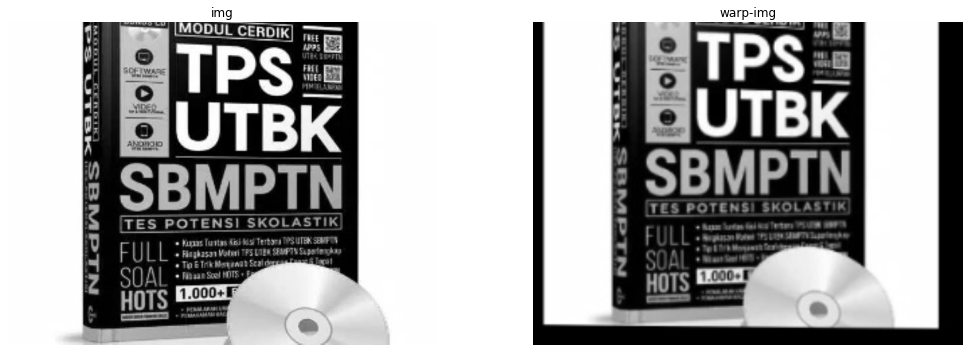

<Figure size 432x288 with 0 Axes>

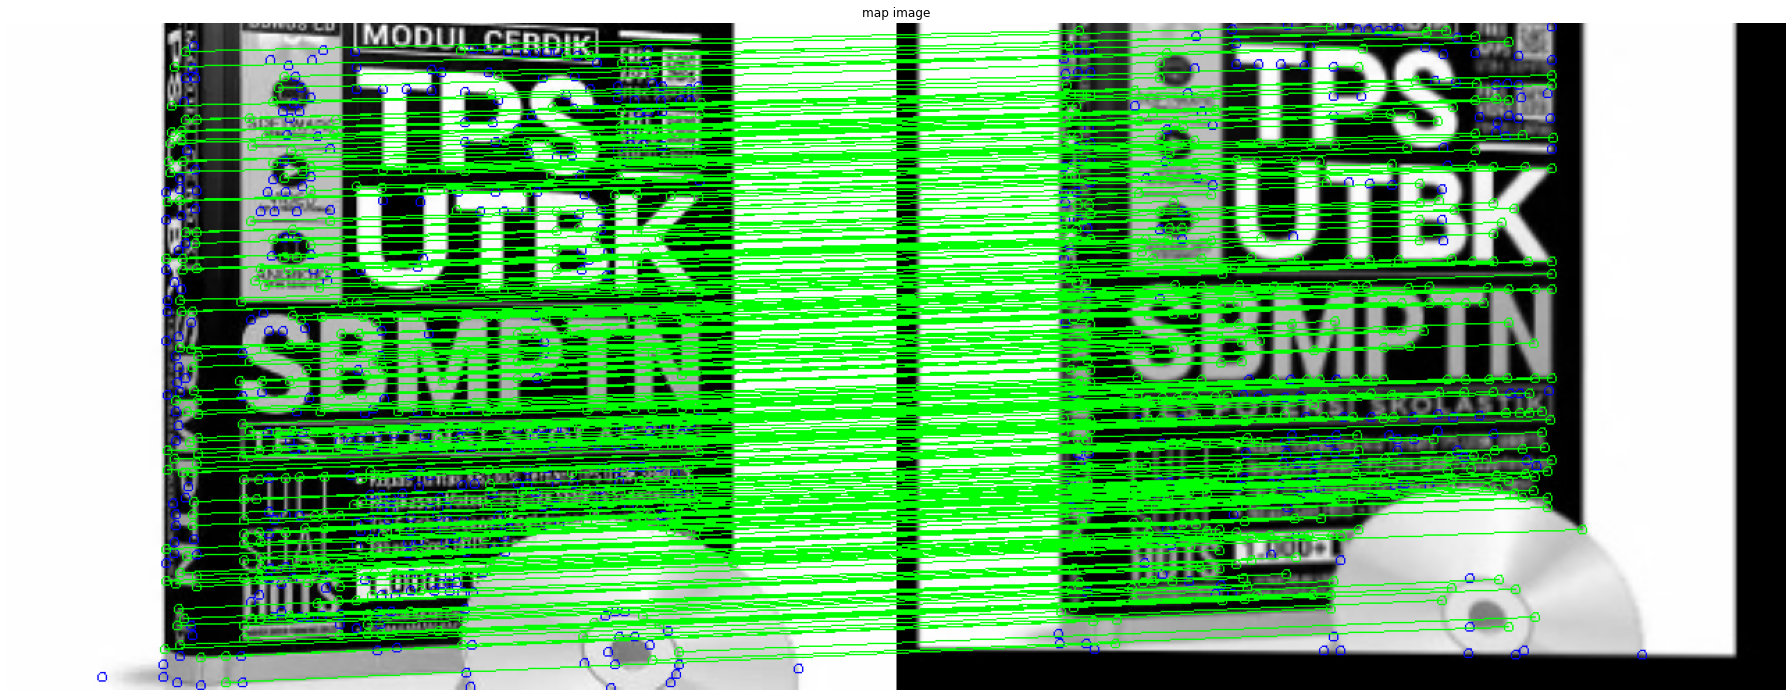

In [703]:
##################################################################################################
## Utilize above functions to generate image iterator in tensorflow.
## from Pm_Util import getDataIter
import tensorflow as tf
from matplotlib.gridspec import GridSpec


num_images_per_shape = 1
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pmpatches-3"
image_dir = 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\shopee-product-matching\\train_images'
config_file = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\Superpoint\\superpoint\configs\\superpoint_pmpatches.yaml"

# with open(config_file, 'r') as f:
#         config = yaml.load(f)
    
# print('config: ', config)
# resize = config['data']['preprocessing']['resize']
data = getDataIter(data_dir, image_dir, num_images_per_shape)

while True:
    try:
        data_rec = next(data)
        print('...........data_rec fetched................')
        superpoint = data_rec['superpoint']
        image  = superpoint['image']
        warped_image = superpoint['warped_image']
        print('...........calling calculate_match......')
        print(image.shape, warped_image.shape)
        result = calculate_match(superpoint, keep_k_points=1000, correctness_thresh=3)
        printImage([image,warped_image],2,2)
        result['image'] = image
        result['warped_image'] = warped_image
        map_image = draw_matches(result) / 255.
  
        Cols = 1
        fig = plt.figure()
        fig, ax = plt.subplots(1,1, figsize=(25,10))
#         for ax, incr in zip(a,range(0,Cols)):
        ax.imshow(map_image,cmap='gray') #, vmin=0, vmax=255)
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        ax.set_title(str('map image'))

        for spine in ax.spines.values():  # remove frame
            spine.set_visible(False)
        plt.tight_layout()
        
    except tf.errors.OutOfRangeError:
        break


# Match Two different Images

In [7]:
def _path(filename):
    val = Path(filename)
    return str(val)

def _name(filename):
    val = Path(filename).stem
    return val
def _read_super_points2(filename):
    mp = np.load(filename, allow_pickle=True)
    name = _name(filename)
    image = mp['image']
    warped_image = mp['warped_image']
    return [mp['prob'], mp['warped_prob'], mp['desc'], mp['warped_desc'], mp['homography'], name, image, warped_image]


def super_points2(filename):
    pred_result = _read_super_points2(filename)
    f_output=  {'prob': pred_result[0], 'warped_prob': pred_result[1], 
            'desc': pred_result[2], 'warped_desc': pred_result[3], 
            'homography': pred_result[4], 'name': pred_result[5],
            'image': pred_result[6], 'warped_image': pred_result[7]}
    return f_output

## Read CSV file lists.
npz_csv_list_path = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\data\\PM\\test_list.npz"
f = np.load(npz_csv_list_path, allow_pickle=True)

##find fist match
patch_path = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1"
generated_list = [str(f) for f in os.listdir(patch_path)]
match_list = []
max_incr = 10
incr = 1

for files_batch in f['image']:
#     print('files_batch: ', files_batch)
    for file in files_batch:
        if file.replace('.jpg','.npz') in generated_list:
            match_list.append(file.replace('.jpg','.npz'))
    if len(match_list) >= 2:
        print(match_list)
        match_list = []
    else:
        match_list = []


['ce538d5b430e0a4035e844bd55a9642d.npz', 'cadc873c6e7e744ac821a96f1f9c2a75.npz', '564ae7aef43a5e233083e73fabaec3a0.npz']
['05ab3fb7954d9b61c1e18546c8d51eca.npz', '8d21f90a739528572179dfa8a4f3df83.npz', 'bbec592fc26da128a02c5549ce64ba10.npz', '77c5e655cf05da188c64103b320b97f3.npz', '3c318e9e9fca25d0933ad07d42155b0c.npz']
['9b26f9cd898ecad33e66feb26568cf3f.npz', '6d7938289734c48af3f2c7647612c12f.npz', 'a6d9e10d2ef53e2df30ca6baafe6e072.npz']
['a2c217657a173e74bd10fbb57ca388d9.npz', '9baaf689d2569cf92bf280fc6464cde6.npz', '383139eee82f9fbafef0942a33cb3c13.npz']
['3e4d12cd726a3c5f73ad8f1d6f03909e.npz', 'ee13ae97c5304302e4d01aa678bb28c7.npz', '533f7b0a77f38813ab7f114c7ff18d2b.npz']
['dba4ea69827eab32cd69b79bbe2888d0.npz', 'ae53f850586f4caed64a7332f3d9feba.npz', '0bb839eeb70ca5efc87692cbe12a6a2a.npz']
['fcd68627494211f737ab9f2c88188f76.npz', 'a7e943d3e06ffb8f85cec2ce41edaddd.npz', 'feb5df36cf816e820d12c09aa4288077.npz']
['dc26d5d6d5df3c8763862138405ba4e8.npz', 'dd1bd299a77463c07132ae28920a6dd

In [8]:
def select_k_best(points, k):
        """ Select the k most probable points (and strip their proba).
        points has shape (num_points, 3) where the last coordinate is the proba. """
#         print(points.shape)
        sorted_prob = points[points[:, 2].argsort(), :2]
        start = min(k, points.shape[0])
        return sorted_prob[-start:, :].astype(int)

def calculate_match_with_different(data1, data2, keep_k_points=1000, correctness_thresh=3):
    """
    Compute the homography between 2 sets of detections and descriptors inside data.
    """
    prob1 = data1['prob']
    keypoints1 = np.where(prob1 > 0)
    prob1 = prob1[keypoints1[0], keypoints1[1]]
    keypoints1 = np.stack([keypoints1[0], keypoints1[1], prob1], axis=-1)
    top_keypoints1 = select_k_best(keypoints1, keep_k_points)
    desc1 = data1['desc'][top_keypoints1[:, 0], top_keypoints1[:, 1]]

    prob2 = data2['prob']
    keypoints2 = np.where(prob2 > 0)
    prob2 = prob2[keypoints2[0], keypoints2[1]]
    keypoints2 = np.stack([keypoints2[0], keypoints2[1], prob2], axis=-1)
    top_keypoints2 = select_k_best(keypoints2, keep_k_points)
    desc2 = data2['desc'][top_keypoints2[:, 0], top_keypoints2[:, 1]]
        
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc1, desc2)
    matches_idx = np.array([m.queryIdx for m in matches])
    
#     print('matches: ', matches)
    
    if len(matches_idx) == 0:  # No match found
        print('==============No Match Found==================')
        return {'correctness': 0.,
                'keypoints1': top_keypoints1,
                'keypoints2': top_keypoints2,
                'inliers' : [],
                'matches': []}
    
    m_keypoints1 = top_keypoints1[matches_idx, :]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_keypoints2 = top_keypoints2[matches_idx, :]

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(m_keypoints1[:, [1, 0]],
                                    m_keypoints2[:, [1, 0]],
                                    cv2.RANSAC)

    return {
            'keypoints1': top_keypoints1,
            'keypoints2': top_keypoints2,
            'inliers' : np.concatenate(inliers),
            'matches': matches}

range(1, 2, 2) 1
matches.shape, len(inliers):  (245,) 245


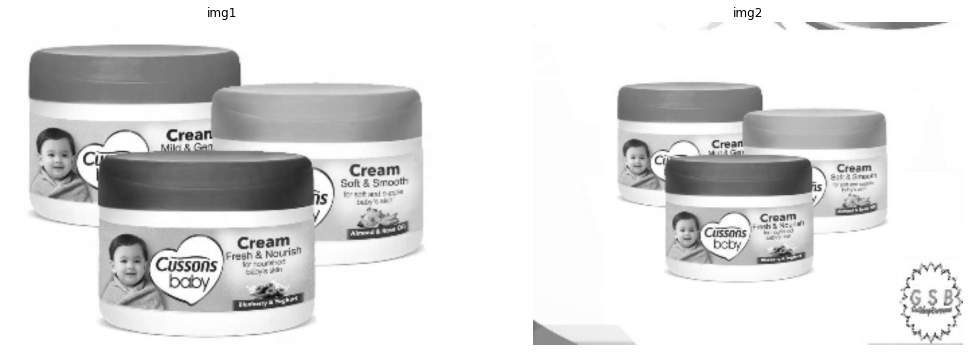

<Figure size 432x288 with 0 Axes>

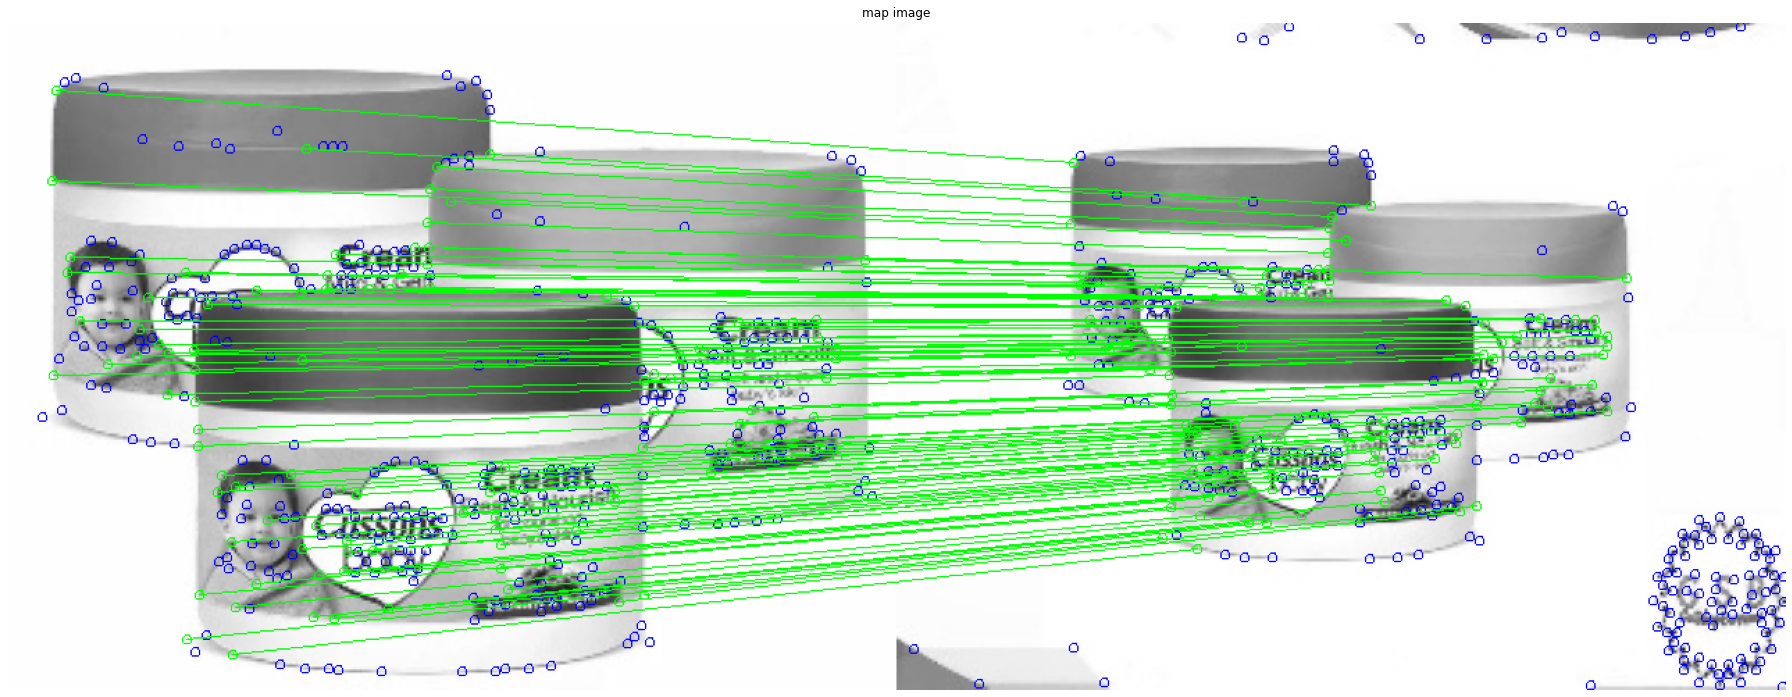

In [11]:
match_list = ['44103cbef5b38a4bde692fe6d2de5b0e.npz', 'f7069aed860d118f7d059dd52f3dab0a.npz', '4f14cb15fc90a4a7cf483b50066ea261.npz']
image  = super_points2(patch_path+'\\'+match_list[0])
warped_image = super_points2(patch_path+'\\'+match_list[1])
# print(image.keys(), warped_image.keys())
result = calculate_match_with_different(image, warped_image, keep_k_points=1000, correctness_thresh=3)
printImage([image['image'],warped_image['image']],2,2)
result['image1'] = image['image']
result['image2'] = warped_image['image']
map_image = draw_matches(result) / 255.

Cols = 1
fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(25,10))

ax.imshow(map_image,cmap='gray') #, vmin=0, vmax=255)
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
ax.set_title(str('map image'))

for spine in ax.spines.values():  # remove frame
    spine.set_visible(False)
plt.tight_layout()